# Time series prediction (Part 2 - 1.5 day)

**NB objectives**
- [ ] Get to use few prediction models
- [ ] Understand what CV is for

**Required librairies**
- [ ] matplotlib
- [ ] numpy
- [ ] pandas
- [ ] seaborn
- [ ] pmdarima

## SARIMA: Dealing now with seasonality

As previously seen, ARIMA model is for stationary data. It may even works for data presenting seasonality. However, seasonality is not clearly expressed. If data shows seasonality less simple as for the airport's data, calculation complexity and time can explode. E.g. data compiling sun activity with a seasonality of 12 +/-1 year would require a minimum of *p = 12 year x 12 months* to comprehend seasonality of the problem.

One way could be to deal with the tendency and the seasonality with one model coupled with another one that deals with the variability inside the seasonality. **Here comes SARIMA: Seasonal-ARIMA!**

To start, define what are the parameter of the SARIMA model. The parameters are written (p, d, Q), (P, D, Q)m.
1. Read the documentation from the page 15: [click here](https://people.duke.edu/~rnau/Slides_on_ARIMA_models--Robert_Nau.pdf)
1. What are the P,D, Q and m?
2. What are the p,d and q?
3. What could mean *(1, 0, 1) (1, 1, 2)12*?

`answer here`

### Manage data for SARIMA

In [3]:
from pandas import date_range
from pmdarima.datasets import load_airpassengers

In [4]:
START_DATE = "1949-01-01"
airline = load_airpassengers(as_series=True)

# there's no datetimeindex from the bundled dataset. So let's add one.
airline.index = date_range(START_DATE, periods=len(airline), freq="MS")

In [5]:
# train / test split here


def ts_train_test_split(data, split_date):
    """
    Split time series into training and test data

    Parameters:
    -------
    data - pd.DataFrame - time series data.  Index expected as datatimeindex
    split_date - the date on which to split the time series

    Returns:
    --------
    tuple (len=2)
    0. pandas.DataFrame - training dataset
    1. pandas.DataFrame - test dataset
    """
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]
    return train, test

# hold back the last twelve months as a TEST set
train, test = ts_train_test_split(airline / airline.index.days_in_month, "1959-01-01")

### Evaluate the parameters of the S-ARIMA

We already know that the airline serie is seasonal, and we know that it is a yearly one. But let's respect the methodology.

1. Remember, as view in the first notebook of the module, we need to determine the seasonality before building a S-ARIMA model.
    - you can use visual tools such as `decompose` or `decomposed_plot` from `pmdarima`
    - you can use ACF or PACF plots.
    - or you can use statistic tests.
2. Once you know the seasonality, we should work on the integration to establish all the parameter of the S-ARIMA models from ACF and PACF plots.

#### Determine the seasonality from visualization

To get the seasonality you can use the function `decompose` and `decomposed_plot` from `pmdarima`. Plot with different lag and observe the results. When you get a periodic signal for seasonality without seasonality for trend and random (=residue), you can conclude you have a seasonal signal and its length of seasonality.

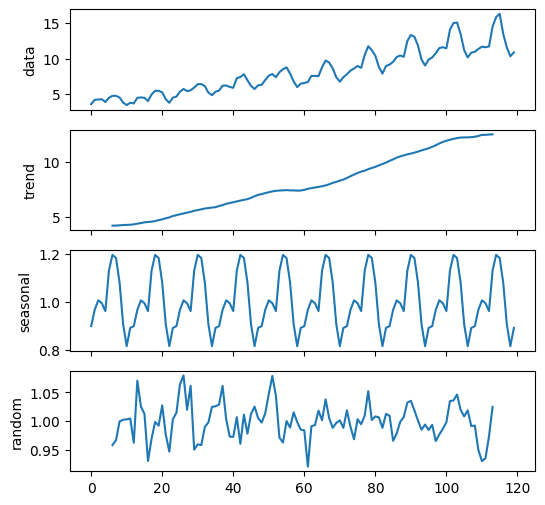

In [9]:
# your code to get the seasonality with plots.

# additive because the original signal is multiplicative, but we are in log.
from pmdarima import decompose
from pmdarima.utils import decomposed_plot
import matplotlib.pyplot as plt

decomposed = decompose(train.values, "multiplicative", m=12)
decomposed_plot(decomposed, figure_kwargs={"figsize": (6, 6)}, show=False)
plt.show()

What is the seasonality?  
`reply here`

You can also use the PACF and ACF plots. The "bridge" shape on ACF and high correlation every `n` lag means oftentimes that the signal is seasonal.

In [ ]:
# your code with ACF and PACF on the raw signal.

#### Evaluate the seasonality from statistics

Until this moment, we use some visual tool to evaluate the stationarity. But statistical tools exist.
1. Look at the documentation about `nsdiffs`: [click here](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#estimating-the-seasonal-differencing-term-d)
2. Write the code to evaluate the stationary and the integration `D`.

In [ ]:
# code here

### Evaluate the parameters of SARIMA (OPTIONAL - Pass below, if you struggle on this part)

#### Determine the integration parameters

We have strong assumptions about the length of the seasonality $m$. Now, we can evaluate the values of the $(p, d, q)(P, D, Q)_m$ parameters.

To do so, try to get a stationnary signal with the data by integrate the signal at the first or second level, or both:
1. the seasonal level (to get the *D*), if there is a strong seasonal component.
2. and the inter-seasonal level (to get the *d*) if there is a trend.

What are the integration to get a stationnary signal? Reply below your code.

Attention: Do not use `log` this time.

In [122]:
# see two function that can help you to evaluate the rolling mean and variance, so evaluate the stationnarity with plots.
import numpy as np

def rolling_mean(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

def rolling_std(a, n=3):
    j = len(a) - n
    mov_std = np.array([np.std(a[k : k + n]) for k in range(j)])
    return mov_std

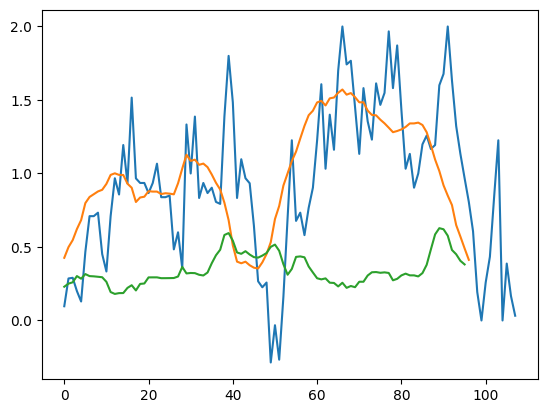

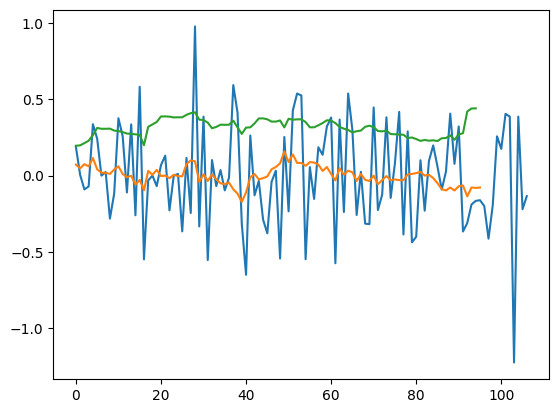

In [128]:
# your code here to get a stationnary signal from the time series by one integration on interseasonal scale, seasonal one or both.
# Use the plots to validate your transformation.

x = train.values # d = 0
x = x[12:] - x[:-12]  # D = 1

plt.plot(x)
plt.plot(rolling_mean(x, 12)) 
plt.plot(rolling_std(x, 12))
plt.show()

x = np.diff(train.values) # d = 1
x = x[12:] - x[:-12] # D = 1

plt.plot(x)
plt.plot(rolling_mean(x, 12))
plt.plot(rolling_std(x, 12))
plt.show()

What are the values of the integration paramters $d$ and $D$?  
`reply here`

#### Determine the correlation parameters

- With ACF and PACF plots, determine all the other parameters. (Read the first documentation provided above).

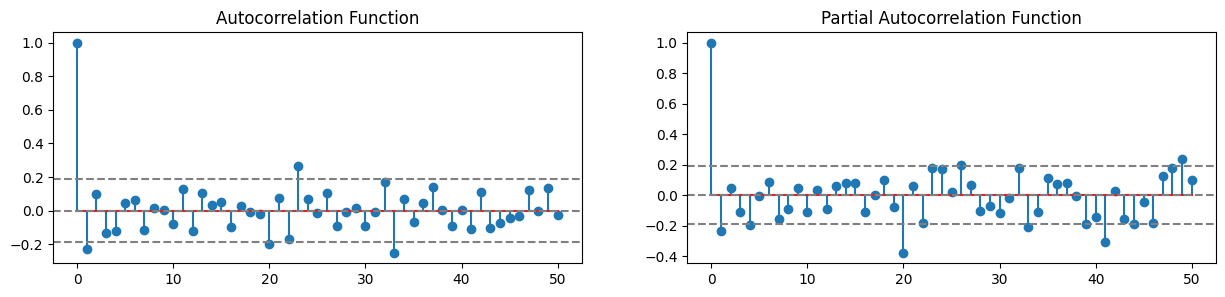

In [13]:
# ACF & PACF plots
from pmdarima.utils import acf, pacf
import numpy as np

x = np.diff(train.values)  # d = 1
x = x[12:] - x[:-12]

n_sample = len(x)
lag_acf = acf(x, nlags=50)
lag_pacf = pacf(x, nlags=50)

pct_95 = 1.96 / np.sqrt(n_sample)

plt.figure(figsize=(15, 3))
# Plot ACF:
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(y=-pct_95, linestyle="--", color="gray")
plt.axhline(y=pct_95, linestyle="--", color="gray")
# plt.axvline(x=q, color='black', linestyle='--', label=f'q={q}')
# plt.legend()
plt.title("Autocorrelation Function")

# Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle="--", color="gray")
plt.axhline(
    y=-pct_95, linestyle="--", color="gray"
)  # represente 95 % des données d'une gaussienne
plt.axhline(
    y=pct_95, linestyle="--", color="gray"
)  # represente 95 % des données d'une gaussienne
# plt.axvline(x=p, color='black', linestyle='--', label=f'p={p}')
plt.title("Partial Autocorrelation Function")
# plt.legend()
plt.show()

In case, the answer is $(0, 1, 1)(0, 1, 1)_{12}$.  
Is it coherent with your plots?  
How do you justify these numbers?

`reply here`

## Build your model

1. build the SARIMA model with ARIMA class from `pmdarima`: [click here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html)
2. Train and evaluate your model. Select a metric for TS. [Click here](https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27)
3. Is it better than the classical ARIMA model without seasonal order?

In [ ]:
# your code here

`your observations and conclusion here`

## Optional: Redo the work but on another dataset

1. Select another dataset:
- from `pmdarima` between: `['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']`
- or from https://data.world/datasets/time-series 

2. realize the same work as above.

In [ ]:
import pmdarima

dataset_names = ['airpassengers', 'ausbeer', 'austres', 'gasoline', 'heartrate', 'lynx', 'msft', 'sunspots', 'taylor', 'wineind', 'woolyrnq']
def get_ds(ds_name, red_factor=None):
    '''
    Loads a dataset of pmdarima from its ds_name.
    '''
    ds = getattr(pmdarima.datasets, 'load_'+ds_name)(as_series=True).dropna()
    if red_factor is not None:
        assert isinstance(red_factor, int)
        ds= ds.groupby(np.arange(ds.index.shape[0])//red_factor).mean()
    return ds

In [ ]:
#### Write your code here